# Binary classification (Trauma detection)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

GLB_INSTALL_DEPENDENCIES = False
GLB_USE_DRIVE_ACCOUNT = False

In [2]:
# Here to define dependencies
if GLB_INSTALL_DEPENDENCIES:
    !pip install transformers
    !pip install torch
    !pip install openpyxl
"""
if GLB_USE_DRIVE_ACCOUNT:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/"Colab Notebooks"
  username = "IsaacOlguin"
  repository =  "AutomatedTraumaDetectionInGCT"
  %cd {repository}
  %pwd
"""

'\nif GLB_USE_DRIVE_ACCOUNT:\n  from google.colab import drive\n  drive.mount(\'/content/drive\')\n  %cd /content/drive/MyDrive/"Colab Notebooks"\n  username = "IsaacOlguin"\n  repository =  "AutomatedTraumaDetectionInGCT"\n  %cd {repository}\n  %pwd\n'

In [3]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

import src.classification_model_utilities as mlclassif_utilities

## Globals

In [ ]:
PATH_DATASET = "input/dataset/20230112_Dataset_W_Batch1.xlsx" #"input/dataset/Dataset.xlsx"
PATH_DIR_LOGS = "logs/"
PATH_DIR_MODELS = "models/"
INDEX_COLUMNS_DATASET = 1
#LIST_NAME_COLUMNS_DATASET = ["id_document", "id_annotation", "span", "role", "trauma", "court"]
LIST_NAME_COLUMNS_DATASET = ["id_document", "id_annotation", "start", "span", "role", "trauma", "court", "Comments1", "Comments2"]

GLB_RETURN_ATTENTION_MASK = True
GLB_CROSS_VALIDATION = False
GLB_SAVE_MODEL = False
GLB_STORE_STATISTICS_MODEL = False
GLB_TEST_MODEL = False

# Globals for the model
EPOCHS = 3
EMBEDDING_SIZE = 512
NUM_CLASSES = 2
BATCH_SIZE = 8

## Dataset

In [ ]:
df_dataset = mlclassif_utilities.import_dataset_from_excel(PATH_DATASET, INDEX_COLUMNS_DATASET, LIST_NAME_COLUMNS_DATASET)
df_dataset.head()

,id_document,id_annotation,start,span,role,trauma,court,Comments1,Comments2
0,63a16b2597ad59b4cfc56c2d,63a16cd397ad59b4cfc56c4e,997.0,A. Milorad Kicanovic.,Witness,0.0,ICTY,NaN,NaN
1,63a16b2597ad59b4cfc56c2d,63a16cd697ad59b4cfc56c4f,961.0,A. Yes.,Witness,0.0,ICTY,NaN,NaN
2,63a16b2597ad59b4cfc56c2d,63a16cdb97ad59b4cfc56c50,1060.0,A. Because we had worked together in the Auto...,Witness,0.0,ICTY,NaN,NaN
3,63a16b2597ad59b4cfc56c2d,63a16cde97ad59b4cfc56c51,1157.0,A. Serbian.,Witness,0.0,ICTY,NaN,NaN
4,63a16b2597ad59b4cfc56c2d,63a16ce197ad59b4cfc56c52,1230.0,"A. No, he said nothing. He only said, ""I nee...",Witness,0.0,ICTY,NaN,NaN


In [ ]:
classes_dataset = mlclassif_utilities.get_unique_values_from_dataset(df_dataset, "trauma")
print(f"Num of different traumas in the dataset is {len(classes_dataset)} which are:")
for index, elem in enumerate(classes_dataset):
    print("\t", index+1, "-", elem)

Num of different traumas in the dataset is 2 which are:
	 1 - 0.0
	 2 - 1.0


### Distribution of all classes within the dataset

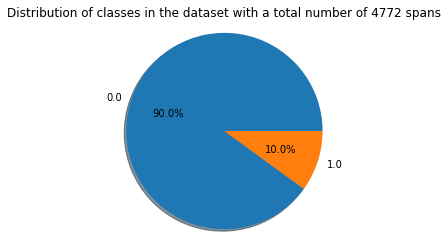

,trauma,span
0,0.0,4294
1,1.0,478


In [ ]:
distribution_classes = mlclassif_utilities.get_distribution_classes_from_dataset(df_dataset, ["trauma"], "span")

labels = list(distribution_classes["trauma"])
sizes = list(distribution_classes["span"])

fig1, ax1 = plt.subplots()
ax1.set_title(f'Distribution of classes in the dataset with a total number of {distribution_classes["span"].sum()} spans')
ax1.pie(sizes, labels=labels, autopct='%2.1f%%', shadow=True, startangle=0) #'%1.1f%%'
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

distribution_classes

## Setup

### Device

Get the GPU device if exists, otherwise get the cpu as default dev.

In [ ]:
device = mlclassif_utilities.get_gpu_device_if_exists()

print(f"\n\n==> Selected device is '{device}' <==")

INFO  There are 1 GPU(s) available.

These are the available devices:
INFO  	 1 - Tesla T4


==> Selected device is 'cuda' <==


## Model

### Tokenizer

In [ ]:
#If no parameters are sent, default values are considered. 
#    IDModel:      Bert
#    Model namel:  bert-base-uncased
#    Do uncase:    True

tokenizer = mlclassif_utilities.get_tokenizer() 

DEBUG Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

INFO  Bert tokenizer was loaded successfully (bert-base-uncased)
	do_lower_case=True


In [ ]:
list_all_spans = list(df_dataset["span"])
list_all_classes = list(df_dataset["trauma"])

### Max length of a sentence among all sentences within the dataset

In [ ]:
mlclassif_utilities.get_max_length_of_a_sentence_among_all_sentences(tokenizer, list_all_spans, False)

INFO  Max sentence length: 298 found at index 4682. Sentence is:


A. <There was a> committee of monks at the level of the province which <the chief> was in charge. I was in charge of the New People, their living conditions, their health; I was in charge of meetings and the kitchens. <So many people were sick. So, I prepared food for them. One person was> very hungry; <so he ate> so <much food> that <he> fainted. He did not die, but nearly died. We divided our roles. As regards the monks, what I can tell you is that they were <defrocked> but I do not know why. <But, my> idea at the time was that they should be kept, they shouldn't be <defrocked since they were already old> but <we should not allow more people to be ordained. I said that, but I did not dare to say it loud enough to be heard. I talked and walked the talk at the same time, but for fear, I did not dare to talk loudly. The state of life was like that.> I was at the pagoda. <I looked after it>. I <used the wooden boards to t

298

### Tokenize sentences

In [ ]:
# If _return_attention_mask, a tuple of two lists is given (tensor_of_inputs, tensor_of_attention_masks)
all_spans_tokenized = mlclassif_utilities.get_all_spans_tokenized(
    mlclassif_utilities.GLB_BERT_MODEL_ID, 
    tokenizer,
    list_all_spans,
    _add_special_tokens = True, 
    _max_length = 512,
    _pad_to_max_length = True,
    _return_attention_mask = GLB_RETURN_ATTENTION_MASK, 
    type_tensors = mlclassif_utilities.GLB_PYTORCH_TENSOR_TYPE
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids = None
attention_masks = None

if GLB_RETURN_ATTENTION_MASK:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[0])
    attention_masks = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized[1])
else:
    input_ids = mlclassif_utilities.convert_list_into_pytorch_tensor(all_spans_tokenized)

### Split dataset

In [ ]:
numeric_classes = mlclassif_utilities.convert_list_span_classes_into_numeric_values(classes_dataset, list_all_classes)
numeric_classes = mlclassif_utilities.convert_list_labels_into_pytorch_tensor(numeric_classes)

In [ ]:
### Split dataset
if not GLB_CROSS_VALIDATION:
    train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks, test_labels_corpus, test_input_ids, test_attention_masks = mlclassif_utilities.split_dataset_train_val_test(numeric_classes, input_ids, attention_masks)
else:
    ### Pending k-Fold
    train_val_corpus_cross_validation, test_corpus_cross_validation = mlclassif_utilities.split_dataset_train_val_test_k_fold(numeric_classes, input_ids, attention_masks, 0.1)

    #test_labels_corpus, test_input_ids, test_attention_masks = 
    #train_labels_corpus, train_input_ids, train_attention_masks, val_labels_corpus, val_input_ids, val_attention_masks,

INFO  
CORPUS TRAINING AND VALIDATION: 
            
	 Length labels 4533
            
	 Length input_ids 4533
            
	 Length attention_masks 4533
            

INFO  
	CORPUS TRAINING:  
            
		 Length labels 4079
            
		 Length input_ids 4079
            
		 Length attention_masks 4079
INFO  
	CORPUS VALIDATION: 
            
		 Length labels 454
            
		 Length input_ids 454
            
		 Length attention_masks 454
INFO  
INFO  
CORPUS TEST: 
            
	 Length labels 239
            
	 Length input_ids 239
            
	 Length attention_masks 239
            



### Create datasets and dataloaders

In [ ]:
train_dataset = mlclassif_utilities.create_tensor_dataset(train_input_ids, train_attention_masks, train_labels_corpus)
val_dataset = mlclassif_utilities.create_tensor_dataset(val_input_ids, val_attention_masks, val_labels_corpus)
test_dataset = mlclassif_utilities.create_tensor_dataset(test_input_ids, test_attention_masks, test_labels_corpus)

train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)
test_dataloader = mlclassif_utilities.create_dataloader(test_dataset, BATCH_SIZE)

### Create model

In [ ]:
model = mlclassif_utilities.create_model(
    mlclassif_utilities.GLB_BERT_MODEL_ID,
    mlclassif_utilities.GLB_BERT_BASE_UNCASED_MODEL_NAME,
    NUM_CLASSES,
    True #RunInGPU
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Get optimizer and scheduler

In [ ]:
optimizer = mlclassif_utilities.get_optimizer(model)
scheduler = mlclassif_utilities.get_scheduler(optimizer)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Train and validate the model

In [ ]:
if not GLB_CROSS_VALIDATION:
  train_dataset = mlclassif_utilities.create_tensor_dataset(train_input_ids, train_attention_masks, train_labels_corpus)
  val_dataset = mlclassif_utilities.create_tensor_dataset(val_input_ids, val_attention_masks, val_labels_corpus)
  test_dataset = mlclassif_utilities.create_tensor_dataset(test_input_ids, test_attention_masks, test_labels_corpus)

  train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
  val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)
  test_dataloader = mlclassif_utilities.create_dataloader(test_dataset, BATCH_SIZE)

  model, statistics_model = mlclassif_utilities.train_and_validate(model, device, EPOCHS, optimizer, scheduler, train_dataloader, val_dataloader, numeric_classes.tolist())

else:
  list_statistics = list()
  for index_cross_val in range(len(train_val_corpus_cross_validation)):
    train_dataset = mlclassif_utilities.create_tensor_dataset(train_val_corpus_cross_validation[index_cross_val][1], train_val_corpus_cross_validation[index_cross_val][2], train_val_corpus_cross_validation[index_cross_val][0])
    val_dataset = mlclassif_utilities.create_tensor_dataset(train_val_corpus_cross_validation[index_cross_val][4], train_val_corpus_cross_validation[index_cross_val][5], train_val_corpus_cross_validation[index_cross_val][3])

    train_dataloader = mlclassif_utilities.create_dataloader(train_dataset, BATCH_SIZE)
    val_dataloader = mlclassif_utilities.create_dataloader(val_dataset, BATCH_SIZE)

    print('='*50)
    print(f"Cross-Validation Split {(index_cross_val+1)}/{len(train_val_corpus_cross_validation)}")
    print('='*50)
    model, statistics_model = mlclassif_utilities.train_and_validate(model, device, EPOCHS, optimizer, scheduler, train_dataloader, val_dataloader, numeric_classes.tolist())
    list_statistics.append(statistics_model)
    
  if GLB_STORE_STATISTICS_MODEL:
    mlclassif_utilities.save_json_file_statistics_model(list_statistics, PATH_DIR_LOGS)

DEBUG 
INFO  ======== Epoch 1 / 3 ========
INFO  Training...
DEBUG   Batch   100  of    510.    Elapsed: 0:01:12.
DEBUG   Batch   200  of    510.    Elapsed: 0:02:25.
DEBUG   Batch   300  of    510.    Elapsed: 0:03:37.
DEBUG   Batch   400  of    510.    Elapsed: 0:04:50.
DEBUG   Batch   500  of    510.    Elapsed: 0:06:03.
INFO  Epoch 1 : 
            Train_acc : 0.9047035069177279
            Train_precision (macro, micro): [0.67605045 0.90470351]
            Train_recall  (macro, micro): [0.57549619 0.90470351]
            Train_F1 : [0.59210339 0.90470351]
DEBUG 
INFO    Average training loss: 0.24
INFO    Training epoch took: 0:06:10
INFO  Classification report. TRAINING at epoch 1 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      3670
           1       0.68      0.39      0.50       409

    accuracy                           0.92      4079
   macro avg       0.81      0.69      0.73      4079
weighted avg       0.91      0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DEBUG   Batch   100  of    510.    Elapsed: 0:01:13.
DEBUG   Batch   200  of    510.    Elapsed: 0:02:26.
DEBUG   Batch   300  of    510.    Elapsed: 0:03:38.
DEBUG   Batch   400  of    510.    Elapsed: 0:04:51.
DEBUG   Batch   500  of    510.    Elapsed: 0:06:04.
INFO  Epoch 3 : 
            Train_acc : 0.9789709002627798
            Train_precision (macro, micro): [0.95448322 0.9789709 ]
            Train_recall  (macro, micro): [0.92542618 0.9789709 ]
            Train_F1 : [0.93909482 0.9789709 ]
DEBUG 
INFO    Average training loss: 0.08
INFO    Training epoch took: 0:06:11
INFO  Classification report. TRAINING at epoch 3 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3670
           1       0.91      0.89      0.90       409

    accuracy                           0.98      4079
   macro avg       0.95      0.94      0.95      4079
weighted avg       0.98      0.98      0.98      4079

DEBUG 
INFO  Running Validation...
I

### Test model

In [ ]:
if GLB_TEST_MODEL:
    mlclassif_utilities.test_model(model, device, test_dataloader, numeric_classes.tolist())

### Save model

In [ ]:
if GLB_SAVE_MODEL:
    mlclassif_utilities.save_model(model, "model_bert_2_classes", PATH_DIR_MODELS)